# Implementation of the Quantum Pennylane Lambeq Original pipeline

Code based on the the Quantum transfer learning pennylane tutorial but adapted for an NLP use case.

\+ Based on the Quantum NLP with the lambeq–PennyLane integration tutorial

https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning

https://pennylane.ai/blog/2023/04/quantum-nlp-with-the-lambeq-pennylane-integration/

The goal here is to reimplement the original alpha code

--> Using Word embeddings

--> Then PCA

--> Then MLP

Then concat every output vector of each words of a sentence
Finally feed it as params to our model

## Basic Imports

In [84]:
import os
import warnings
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [85]:
import numpy as np
import torch
import json

## Seed everything for reproductibility

In [86]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)


In [87]:
seed_everything(0)

## Inputting the data

The dataset is created from a JSON file of size (3500, 4).

Each example has 3 features: Class, Sentence, Tree, Sentence_vectorized.

The Sentence_vectorized corresponds to a list of the BERT embeddings of every words in each sentences

In [88]:
#Dimension of the reduced word embedding by PCA
REDUCED_WORD_EMBEDDING_DIMENSION = 22

In [89]:
def custom_list_reshaper(array):
        """ reshapes [[[x]],[[y]],...] into [[x],[y],...]"""
        
        new_array = []
        for sub_array in array:
            new_array.append(sub_array[0])
        return new_array

In [90]:
def fit_pca(df, n_components):
    """ applies pca to the array and returns the reduced array"""
    # Convert each array to NumPy array
    np_array = df['sentence_vectorized'].apply(np.array)

    # Concatenate the NumPy arrays into a single array
    np_array = np.concatenate(np_array)

    pca = PCA(n_components=n_components)
    pca.fit(np_array)

    print('PCA explained variance:', pca.explained_variance_ratio_.sum())

    return pca


In [91]:
def preprocess_single_dataset(file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    with open(file) as f:
        data = json.load(f)
        df_dataset = pd.DataFrame(data)
        df_dataset["class"]= df_dataset["class"].map({"2": 1, "1": 0})

    df_dataset['sentence_vectorized'] = df_dataset['sentence_vectorized'].apply(lambda x: custom_list_reshaper(x))

    pca = fit_pca(df_dataset, REDUCED_WORD_EMBEDDING_DIMENSION)
    df_dataset['sentence_vectorized'] = df_dataset['sentence_vectorized'].apply(lambda x: pca.transform(x))

    X_train, X_test, y_train, y_test = train_test_split(df_dataset[['sentence', 'sentence_vectorized']], df_dataset['class'], test_size=0.2)

    return X_train, X_test, y_train, y_test

In [92]:
def preprocess_train_test_dataset(train_csv_file, test_csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_train = pd.read_csv(train_csv_file)
    df_test = pd.read_csv(test_csv_file)


    #df_train['sentence_vectorized'] = df_train['sentence_vectorized'].apply(lambda x: custom_list_reshaper(x))
    #df_test['sentence_vectorized'] = df_test['sentence_vectorized'].apply(lambda x: custom_list_reshaper(x))

    df_train['sentence_vectorized'] = df_train['sentence_vectorized'].apply(ast.literal_eval)
    df_test['sentence_vectorized'] = df_test['sentence_vectorized'].apply(ast.literal_eval)

    pca = fit_pca(df_train, REDUCED_WORD_EMBEDDING_DIMENSION)
    df_train['sentence_vectorized'] = df_train['sentence_vectorized'].apply(lambda x: pca.transform(x))
    df_test['sentence_vectorized'] = df_test['sentence_vectorized'].apply(lambda x: pca.transform(x))

    #Preprocess labels
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df_train['class'].append(df_test['class']))

    df_train['class'] = label_encoder.transform(df_train['class'])
    df_test['class'] = label_encoder.transform(df_test['class'])

    X_train, y_train, X_test, y_test = df_train[['sentence_vectorized', 'sentence']], df_train['class'], df_test[['sentence_vectorized', 'sentence']], df_test['class']

    return X_train, X_test, y_train, y_test

In [93]:
#X_train, X_test, y_train, y_test = preprocess_single_dataset('../../../../data/amazonreview_reduced_bert_train.json')
X_train, X_test, y_train, y_test = preprocess_train_test_dataset('../../../../data/toy_dataset/toy_dataset_bert_word_embedding_train.csv', '../../../../data/toy_dataset/toy_dataset_bert_word_embedding_test.csv')

PCA explained variance: 0.9764395012383982


In [10]:
#For testing purposes
#X_train = X_train[0:400]
#y_train = y_train[0:400]
#X_test = X_test[0:100]
#y_test = y_test[0:100]

## Creating and parameterizing diagrams

In [94]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train['sentence'].values.tolist(), suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_test['sentence'].values.tolist(), suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [95]:
from lambeq import Rewriter
# Apply rewrite rule for prepositional phrases

rewriter = Rewriter(['prepositional_phrase', 'determiner', 'curry'])

raw_train_diagrams = [rewriter(diagram) for diagram in raw_train_diagrams]
raw_val_diagrams = [rewriter(diagram) for diagram in raw_val_diagrams]

In [96]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, y_train)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, y_test)
    if diagram is not None
]

In [97]:
train_diagrams.__len__()

80

## Creating circuits

In [98]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=4, n_single_qubit_params=3)

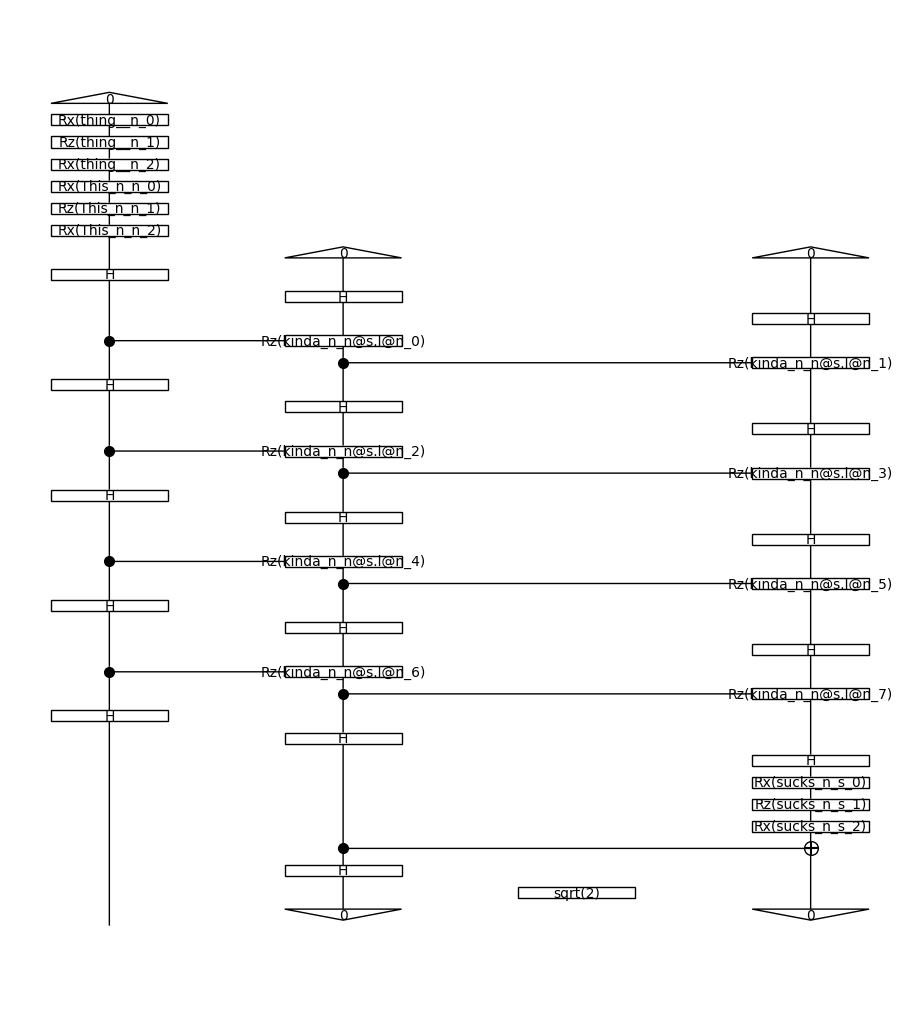

In [99]:
train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Hybrid QNLP Model

In [100]:
BATCH_SIZE = 2048
EPOCHS = 50
SEED = 2
LR = 5e-2
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20

In [101]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class DressedQuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.pre_qc_output_size = None

        self.pre_qc = None

        self.param_indexes_dict = {}
        
        self.post_qc = nn.Sequential(nn.Linear(2, 1),
                                nn.Sigmoid())

    
    # To be called after the model is initialized
    ##############################################################################################################
    def update_pre_qc_output_size(self):
        """
        Find the output size of the pre_qc neural network + Create the pre_qc neural network.
        """
        self.pre_qc_output_size = self.find_pre_qc_output_size()
        self.pre_qc = nn.Sequential(nn.Linear(REDUCED_WORD_EMBEDDING_DIMENSION, self.pre_qc_output_size),
                                    nn.LeakyReLU(0.01))

    def find_pre_qc_output_size(self):
        """
        Find the output size of the pre_qc neural network.
        It is the maximum number of parameters in all the circuits.
        """
        max_number_of_params = 0
        for circuit_pennylane in list(self.circuit_map.values()):
            if circuit_pennylane._symbols.__len__() > max_number_of_params:
                max_number_of_params = circuit_pennylane._symbols.__len__()

        return max_number_of_params
    
    def find_param_indexes_from_diagram_dict(self, diagrams):
        """
        Given a diagram, find the indexes of the parameters in the model.
        Do it once and for all in the init function
        Return a dictionary with the diagram as key and the list of indexes as value.
        """
        for diagram in diagrams:
            diagram_symbols = self.circuit_map[diagram]._symbols
            model_symbols = self.symbols

            param_indexes = []

            for symbol in diagram_symbols:
                try:
                    param_indexes.append(model_symbols.index(symbol))
                except ValueError:
                    print(f"Symbol {symbol} not found in model symbols")
                    return None
                
            self.param_indexes_dict[diagram] = param_indexes
    ##############################################################################################################    
    

    def update_weights_from_embedding(self, param_indexes, param_values):
        """
        Given a list of indexes and a list of values, update the weights of the model
        """
        for index, value in zip(param_indexes, param_values):
            self.weights[index] = torch.nn.Parameter(torch.tensor(value))


    def forward(self, diagrams, embedding_list):
        ## Here we go through lists of diagrams and bert embeddings because the Pytorch dataloader returns lists (uses batch)
        # pass the embedding through a simple neural network
        #embedding_out = self.pre_qc(bert_embeddings)
        #print(embedding_out.shape)

        sentence_q_params = []
        for embedding in embedding_list:
            # Here 'embedding' is a list of embeddings for each word in the sentence
            post_qc_output = self.pre_qc(embedding)

            post_qc_output = torch.sum(post_qc_output, dim=0)
            sentence_q_params.append(post_qc_output)

        # update the corresponding weights of the model
        param_indexes_list = [self.param_indexes_dict[diagram] for diagram in diagrams]

        # update the weights of the model
        [self.update_weights_from_embedding(param_indexes, embedding) for param_indexes, embedding in zip(param_indexes_list, sentence_q_params)]

        # evaluate the circuits
        qc_output = self.get_diagram_output(diagrams)
        
        # pass the concatenated results through a simple neural network
        return self.post_qc(qc_output)


### Creating the train/valid datasets

In [102]:
all_circuits = train_circuits + val_circuits

In [103]:
from lambeq import Dataset

# initialise datasets and optimizers as in PyTorch
train_dataset = Dataset(list(zip(train_circuits, X_train['sentence_vectorized'].apply(np.array))),
                        train_labels,
                        batch_size=BATCH_SIZE)

valid_dataset = Dataset(list(zip(val_circuits, X_test['sentence_vectorized'].apply(np.array))),
                        val_labels,
                        batch_size=BATCH_SIZE)


### Initializing the model

In [104]:
model = DressedQuantumModel.from_diagrams(all_circuits, probabilities=True, normalize=True)
# initialise our model by pas sing in the diagrams, so that we have trainable parameters for each token
model.initialise_weights()
model.update_pre_qc_output_size()
model.find_param_indexes_from_diagram_dict(all_circuits)
model = model.double()

In [105]:
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=STEP_LR, gamma=GAMMA_LR
)

### Initializing Tensorboard to log our results

In [106]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/fit_pennylane_lambeq_original/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

### Training loop

In [107]:
best = {'acc': 0, 'epoch': 0}
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []

for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    running_loss = 0.0
    running_corrects = 0

    #for circuits, embeddings, labels in train_dataloader:
    for input, labels in train_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()

        embedding_list = [torch.tensor(embedding) for embedding in embeddings]

        predicted = model(circuits, embedding_list)

        # use BCELoss as our outputs are probabilities, and labels are binary
        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        #running_loss += loss.item()
        running_loss += loss.item()*batch_size_
        loss.backward()
        optimizer.step()

        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects
        


    # Print epoch results
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)
    

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)


    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    running_loss = 0.0
    running_corrects = 0

    # evaluate on valid set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    for input, labels in valid_dataset:
        batch_size_ = len(input)
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        
        embedding_list = [torch.tensor(embedding) for embedding in embeddings]

        predicted = model(circuits, embedding_list)

        loss = criterion(torch.flatten(predicted), torch.DoubleTensor(labels))
        running_loss += loss.item()*batch_size_


        batch_corrects = (torch.round(torch.flatten(predicted)) == torch.DoubleTensor(labels)).sum().item()
        running_corrects += batch_corrects


    validation_loss = running_loss / len(valid_dataset)
    validation_acc = running_corrects / len(valid_dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    exp_lr_scheduler.step()
    
    print('Train loss: {}'.format(train_loss))
    print('Valid loss: {}'.format(train_acc))
    print('Train acc: {}'.format(validation_loss))
    print('Valid acc: {}'.format(validation_acc))

    if validation_acc > best_val_acc:
            best_val_acc = validation_acc
            best['epoch'] = epoch
            model.save('nlp_dressed_alpha_model.lt')
    #elif epoch - best['epoch'] >= 10:
    #    print('Early stopping')
    #    break


    if validation_loss < best_val_loss:
        best_val_loss = validation_loss



Epoch: 0
Train loss: 0.7846490492293359
Valid loss: 0.5625
Train acc: 1.2155405185295751
Valid acc: 0.15
Epoch: 1
Train loss: 0.7663969175913277
Valid loss: 0.5625
Train acc: 1.154950516995236
Valid acc: 0.15
Epoch: 2
Train loss: 0.7489940183926846
Valid loss: 0.5625
Train acc: 1.0975676041319395
Valid acc: 0.15
Epoch: 3
Train loss: 0.7332265712445928
Valid loss: 0.5625
Train acc: 1.0443837854183335
Valid acc: 0.15
Epoch: 4
Train loss: 0.719988893709459
Valid loss: 0.5625
Train acc: 0.9965389635389605
Valid acc: 0.15
Epoch: 5
Train loss: 0.7087535102297039
Valid loss: 0.5625
Train acc: 0.9509657501721396
Valid acc: 0.15
Epoch: 6
Train loss: 0.7001151208653551
Valid loss: 0.5625
Train acc: 0.9060822789974006
Valid acc: 0.15
Epoch: 7
Train loss: 0.6934799799760877
Valid loss: 0.5625
Train acc: 0.8661254779243581
Valid acc: 0.15
Epoch: 8
Train loss: 0.6882911616472954
Valid loss: 0.5625
Train acc: 0.8307636286933269
Valid acc: 0.15
Epoch: 9
Train loss: 0.6860643079444978
Valid loss: 0.562

In [25]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

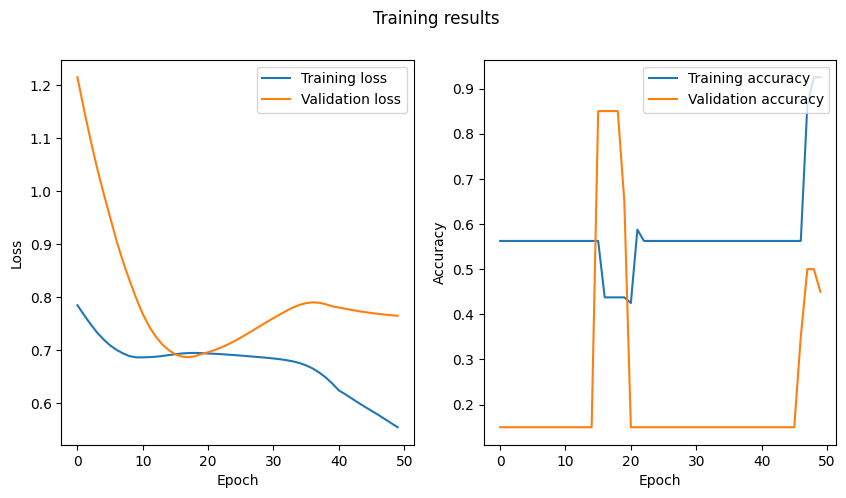

In [108]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)